```markdown
# Importing Libraries

In this Jupyter Notebook, we have imported several libraries that are essential for our tasks. Here is a brief description of each library:

- `os`: This library provides a way to interact with the operating system. We use it to handle file paths and directories.

- `numpy`: This library is used for numerical operations in Python. It provides support for large, multi-dimensional arrays and matrices.

- `tensorflow`: TensorFlow is an open-source machine learning framework. We import it to use its various modules and functions for building and training neural networks.

- `tensorflow.keras`: Keras is a high-level neural networks API written in Python. We import it from TensorFlow to build and train our models.

- `tensorflow.keras.models.Model`: This class is used to define a model architecture in Keras. We import it to create our own custom models.

- `tensorflow.keras.layers`: This module contains various layers that can be used to build neural networks. We import it to add different types of layers to our models.

- `tensorflow.keras.callbacks`: This module provides various callbacks that can be used during the training of a model. We import it to use callbacks like EarlyStopping and ModelCheckpoint.

- `tensorflow.keras.applications`: This module provides pre-trained models that can be used for various tasks. We import it to use models like VGG16 and InceptionResNetV2.

- `tensorflow.keras.preprocessing.image`: This module provides functions for image preprocessing. We import it to load and preprocess images.

- `tensorflow.keras.utils`: This module provides utility functions for working with Keras. We import it to use functions like plot_model.

- `skimage.color`: This module provides functions for color space conversions. We import it to convert images between different color spaces.

- `skimage.io`: This module provides functions for reading and saving images. We import it to read images from files.

- `skimage.transform`: This module provides functions for image transformations. We import it to resize images.

- `matplotlib.pyplot`: This module provides a MATLAB-like plotting interface. We import it to visualize images and plots.

These libraries are essential for our tasks and provide the necessary functionality to build, train, and evaluate our models.
```

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, MaxPooling2D, RepeatVector, Reshape, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

In this cell, we define the directory paths for the training and testing data. The `train_color_dir` variable stores the path to the directory containing the color images for training, while the `train_gray_dir` variable stores the path to the directory containing the grayscale images for training. Similarly, the `test_color_dir` and `test_gray_dir` variables store the paths to the directories containing the color and grayscale images for testing, respectively.

We also define a function called `load_images` that takes the color and grayscale directories as input and loads and processes the images. Inside the function, we list and sort the files in the directories, and then iterate over the common files in both directories. For each file, we read the color and grayscale images, resize them to the specified target size, and convert the color image to the LAB color space. The processed images are then appended to separate lists for color and grayscale images.

After loading and processing the images, we print the counts of the loaded color and grayscale images. Finally, we extract the AB channels from the LAB color images by dividing the color images by 128, and store them in the `y_train_ab` and `y_test_ab` variables for training and testing, respectively.

This cell is responsible for loading and preprocessing the training and testing images, and extracting the AB channels from the color images.

In [5]:
# Directory paths Files/data/image-colorization-via-transfer-learning
train_color_dir = os.path.join('data', 'train_color')
train_gray_dir = os.path.join('data',  'train_black')
test_color_dir = os.path.join('data',  'test_color')
test_gray_dir = os.path.join('data', 'test_black')

# Function to load and process images
def load_images(color_dir, gray_dir, target_size=(256, 256)):
    color_images = []
    gray_images = []

    # List and sort files
    color_files = sorted([f for f in os.listdir(color_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    gray_files = sorted([f for f in os.listdir(gray_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    common_files = set(color_files).intersection(set(gray_files))


    for file in common_files:
        try:
            color_image = imread(os.path.join(color_dir, file))
            gray_image = imread(os.path.join(gray_dir, file))

            # Ensure grayscale image has a single channel
            if gray_image.ndim == 3 and gray_image.shape[2] == 3:
                gray_image = rgb2gray(gray_image)  # Convert to grayscale if needed

        except Exception as e:
            print(f"Error loading file {file}: {e}")
            continue

        # Resize images
        color_image = resize(color_image, target_size)
        gray_image = resize(gray_image, target_size)

        # Convert to LAB for color images
        color_image_lab = rgb2lab(color_image)

        # Append processed images to lists
        color_images.append(color_image_lab)
        gray_images.append(gray_image)

    color_images = np.array(color_images)
    gray_images = np.array(gray_images).reshape(-1, target_size[0], target_size[1], 1)
    
    print("Loaded images:")
    print("Color images count:", len(color_images))
    print("Gray images count:", len(gray_images))
    
    return gray_images, color_images

# Load train and test images
X_train_gray, y_train_color = load_images(train_color_dir, train_gray_dir)
X_test_gray, y_test_color = load_images(test_color_dir, test_gray_dir)
print("Loading Complete")

# Extract the AB channels from the LAB images
y_train_ab = y_train_color[:, :, :, 1:] / 128
print("Extraction Step 1 Complete")

y_test_ab = y_test_color[:, :, :, 1:] / 128
print("Extraction Step 2 Complete")


Loaded images:
Color images count: 5000
Gray images count: 5000
Loaded images:
Color images count: 739
Gray images count: 739
Loading Complete
Extraction Step 1 Complete
Extraction Step 2 Complete


### Checking the Shapes of the Training and Testing Data

To ensure that the training and testing data have been loaded and processed correctly, we can check the shapes of the arrays. The shapes will give us information about the number of samples and the dimensions of the input and output data.

Here is the code to check the shapes of the training and testing data:



In [4]:
# Check the shapes of the training and testing data
print("Shape of X_train_gray:", X_train_gray.shape)
print("Shape of y_train_ab:", y_train_ab.shape)
print("Shape of X_test_gray:", X_test_gray.shape)
print("Shape of y_test_ab:", y_test_ab.shape)

# Ensure the number of samples match
assert X_train_gray.shape[0] == y_train_ab.shape[0], "Mismatch in number of training samples"
assert X_test_gray.shape[0] == y_test_ab.shape[0], "Mismatch in number of testing samples"

StatementMeta(, a32d2d0c-5afd-4eb5-b8c5-6aaf6e53d117, 6, Finished, Available, Finished)

Shape of X_train_gray: (5000, 256, 256, 1)
Shape of y_train_ab: (5000, 256, 256, 2)
Shape of X_test_gray: (739, 256, 256, 1)
Shape of y_test_ab: (739, 256, 256, 2)


This code defines several functions related to image colorization using transfer learning.

### Functions

#### `image_a_b_gen(batch_size, max_batches=10)`
Generates batches of images for training. It takes a batch size and maximum number of batches as input and yields batches of images along with their corresponding colorization targets.

#### `psnr(y_true, y_pred)`
Calculates the Peak Signal-to-Noise Ratio (PSNR) between the true colorized images and the predicted colorized images. It takes the true images and predicted images as input and returns the PSNR value.

#### `ab_to_lab(ab_image, gray_image)`
Converts the AB channels of an image to the LAB color space. It takes the AB channels and the grayscale image as input and returns the LAB image.

#### `check_shapes(lab_image)`
Prints the shape, minimum value, and maximum value of a LAB image. It takes a LAB image as input and does not return anything.

#### `display_lab_channels(lab_image)`
Displays the L, A, and B channels of a LAB image. It takes a LAB image as input and does not return anything.

#### `display_results(bw_images, color_images, predictions, n=3)`
Displays the original black and white images, the colorized images predicted by the model, and the ground truth colorized images. It takes black and white images, color images, predictions, and an optional parameter `n` (number of images to display) as input and does not return anything.

#### `create_inception_embedding(grayscaled_rgb)`
Creates the inception embedding for a batch of grayscale images. It takes grayscale images as input and returns the inception embedding.

In [9]:
def image_a_b_gen(batch_size, max_batches=10):
    batch_count = 0  # Initialize batch counter
    while True:
        if batch_count >= max_batches:
            break  # Stop generating batches after reaching max_batches

        for batch in datagen.flow(X_train_gray, batch_size=batch_size):
            if batch is None or batch.size == 0:
                continue  # Skip empty or invalid batches

            grayscaled_rgb = gray2rgb(batch.squeeze())
            embed = create_inception_embedding(grayscaled_rgb)
            
            lab_batch = rgb2lab(grayscaled_rgb)
            X_batch = lab_batch[:, :, :, 0]
            X_batch = X_batch.reshape(X_batch.shape + (1,))
            Y_batch = lab_batch[:, :, :, 1:] / 128.0

            batch_count += 1  # Increment batch counter
            print(f"Yielding batch {batch_count}/{max_batches}")
            yield ([X_batch, embed], Y_batch)

            if batch_count >= max_batches:
                break  # Stop if the maximum number of batches is reached


# Define PSNR function
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)       

def ab_to_lab(ab_image, gray_image):
    # Ensure gray_image is properly shaped for LAB conversion
    gray_image = gray_image.reshape((256, 256, 1))
    
    # Rescale AB channels from [-1, 1] to [-128, 127]
    ab_image = ab_image * 128
    
    # Create LAB image
    lab_image = np.concatenate([gray_image * 100, ab_image], axis=-1)  # Gray is in [0, 100]
    
    # Ensure LAB image is within valid ranges
    lab_image[..., 1:] = np.clip(lab_image[..., 1:], a_min=-128, a_max=127)
    
    return lab_image
def check_shapes(lab_image):
    print("LAB Image Shape:", lab_image.shape)
    print("LAB Min Value:", np.min(lab_image))
    print("LAB Max Value:", np.max(lab_image))

def display_lab_channels(lab_image):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(lab_image[..., 0], cmap='gray')
    plt.title("L Channel")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(lab_image[..., 1], cmap='gray')
    plt.title("A Channel")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(lab_image[..., 2], cmap='gray')
    plt.title("B Channel")
    plt.axis("off")
    plt.show()
    
def display_results(bw_images, color_images, predictions, n=3):
    num_images = min(n, len(bw_images))
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Display original black and white image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(bw_images[i].reshape(256, 256), cmap='gray')
        plt.title("Original B&W")
        plt.axis("off")

        # Convert predictions to LAB and then to RGB
        lab_pred = ab_to_lab(predictions[i], bw_images[i].reshape(256, 256, 1))
        rgb_pred = lab2rgb(lab_pred)
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(rgb_pred)
        plt.title("Colorized")
        plt.axis("off")

        # Convert ground truth to LAB and then to RGB
        lab_true = ab_to_lab(color_images[i], bw_images[i].reshape(256, 256, 1))
        rgb_true = lab2rgb(lab_true)
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(rgb_true)
        plt.title("Ground Truth")
        plt.axis("off")


def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299))
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = tf.keras.applications.inception_resnet_v2.preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

### U-Net Model Architecture

The U-Net model is a popular architecture for image segmentation tasks. It consists of an encoder-decoder structure with skip connections to preserve spatial information. Here is the code for the U-Net model architecture:

This code defines the U-Net model architecture using the Keras functional API. The model takes an input shape of (256, 256, 1) which represents grayscale images. It consists of an encoder with three convolutional blocks followed by max pooling, a bottleneck layer with two convolutional blocks, and a decoder with three upsampling and concatenation blocks. The final output is a 2-channel image representing the colorized version of the input grayscale image.

To use this model, you can call the `unet_model()` function and pass the desired input shape as an argument. The returned model can then be compiled and trained using appropriate data.

Please note that this code assumes the necessary imports and dependencies are already present in the notebook.

In [12]:
# U-Net Model Architecture
def unet_model(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    outputs = Conv2D(2, (1, 1), activation='tanh', padding='same')(conv7)

    model = Model(inputs, outputs)
    return model

In [17]:
model = unet_model()

# Compile and Train
model.compile(optimizer='adam', loss='mse', metrics=[psnr])

# Train the model using new datasets
model.fit(
    X_train_gray, y_train_ab,
    epochs=50,
    validation_data=(X_test_gray, y_test_ab),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate the Model
print("Evaluate on test data")
results = model.evaluate(X_test_gray, y_test_ab, batch_size=16)
print("Test loss, Test PSNR:", results)

# Visualize Predictions
predictions = model.predict(X_test_gray)

157/157 [==============================] - 3122s 20s/step - loss: 0.0114 - psnr: 20.8984 - val_loss: 0.0120 - val_psnr: 20.9651
Epoch 29/50
1/1 [==============================] - 1s 1s/step
Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 16). These functions will not be directly callable after loading.


2024-08-06 10:59:53.640470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2024-08-06 10:59:53.696327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2024-08-06 10:59:53.752249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2024-08-06

Evaluate on test data
47/47 [==============================] - 159s 3s/step - loss: 0.0116 - psnr: 20.8555
Test loss, Test PSNR: [0.011565831489861012, 20.855457305908203]
24/24 [==============================] - 148s 6s/step


StatementMeta(, 8097ac04-1d2d-43b7-aa80-330e41578d84, 21, Finished, Available, Finished)

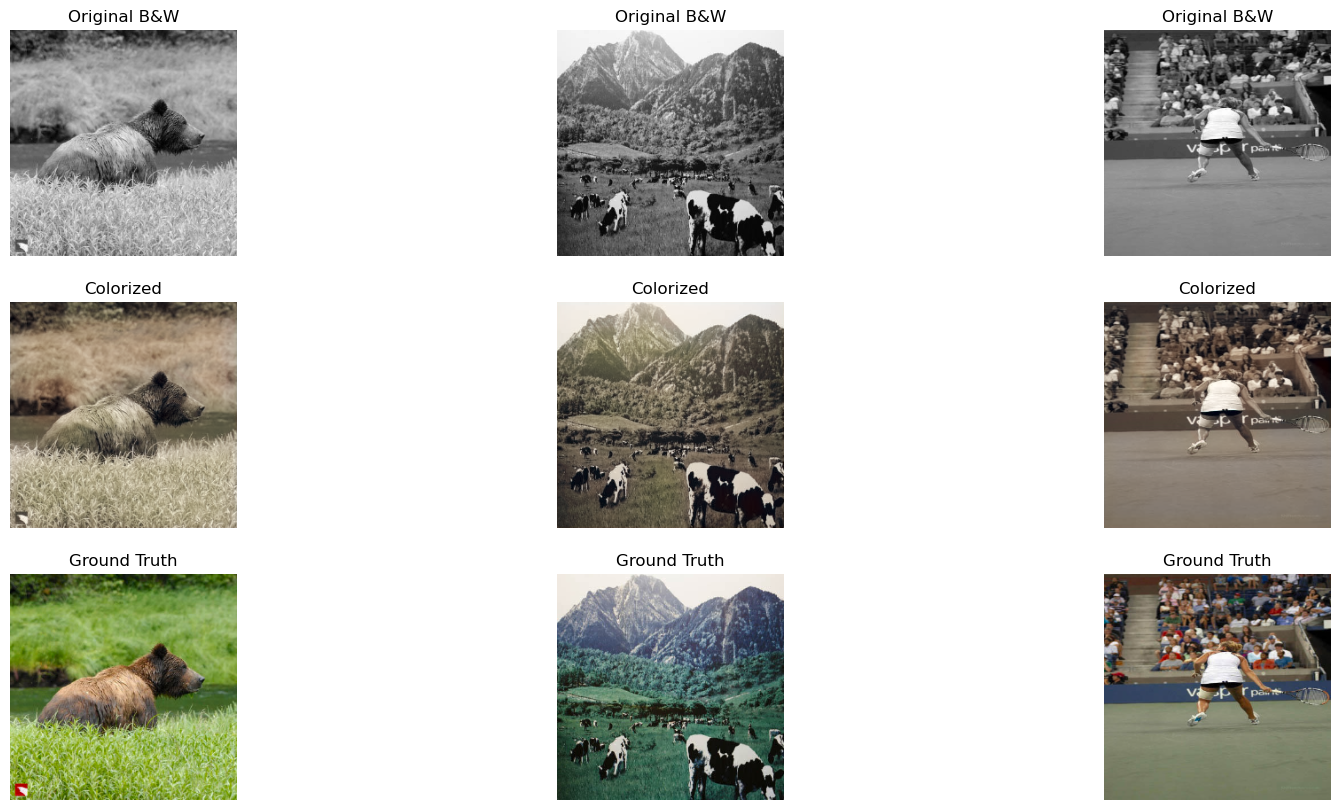

In [19]:
display_results(X_test_gray, y_test_ab, predictions)


In [20]:
model.save(os.path.join('/lakehouse/default','Files','data','image-colorization-via-transfer-learning','unet.h5'))

StatementMeta(, 8097ac04-1d2d-43b7-aa80-330e41578d84, 22, Finished, Available, Finished)

In [32]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

StatementMeta(, 63271998-5a83-4c8c-bc34-85c45632bd95, 34, Finished, Available, Finished)

### Model 2 : Custom Model with VGG16 (Transfer Learning)

The code below defines a function `build_colorization_model()` that builds a colorization model using the VGG16 architecture. Here's a breakdown of the code:

1. Load the pre-trained VGG16 model with weights from the ImageNet dataset and freeze all its layers.
2. Define the input shape for the model.
3. Apply a series of convolutional layers to the input, gradually increasing the number of filters.
4. Convert the 1-channel input to a 3-channel input to match the VGG16 network's input requirements.
5. Pass the modified input through the VGG16 network to extract features.
6. Implement a custom decoder by applying a series of convolutional and upsampling layers to upsample the features.
7. The final output is a 2-channel image representing the colorized version of the input grayscale image.
8. Compile the model using the Adam optimizer and mean squared error loss.
9. Return the compiled model.

After defining the model, the code proceeds to train it using the provided training data. Here's a summary of the training process:

1. Define two callbacks: `early_stopping` to stop training early if the validation loss does not improve for a certain number of epochs, and `model_checkpoint` to save the best model based on the validation loss.
2. Fit the model to the training data, specifying the batch size, number of epochs, validation data, and callbacks.
3. After training, load the weights of the best model based on the validation loss.
4. Predict on the test data using the trained model.


In [28]:
def build_colorization_model():
    # Load the VGG16 model
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Freeze all layers in VGG16
    for layer in vgg.layers:
        layer.trainable = False

    model_input = Input(shape=(256, 256, 1))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(model_input)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Convert 1-channel to 3-channel for VGG input
    x = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

    # Use the VGG16 network for feature extraction
    x = vgg(x)

    # Custom decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(2, (3, 3), activation='tanh', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    model = Model(inputs=model_input, outputs=x)
    model.compile(optimizer='adam', loss='mse')

    return model

# Build the model
model = build_colorization_model()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(os.path.join('/lakehouse/default','Files','data','image-colorization-via-transfer-learning','best_colorization_model.h5'), save_best_only=True, monitor='val_loss')

# Train the model with fewer epochs
model.fit(
    X_train_gray, y_train_ab,
    batch_size=64,  # Increased batch size for faster training
    epochs=20,      # Reduced number of epochs
    validation_data=(X_test_gray, y_test_ab),
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model if needed
model.load_weights(os.path.join('/lakehouse/default','Files','data','image-colorization-via-transfer-learning','best_colorization_model.h5'))

# Predict on test data
output = model.predict(X_test_gray)



StatementMeta(, 8097ac04-1d2d-43b7-aa80-330e41578d84, 30, Finished, Available, Finished)

2024-08-06:11:45:40,347 WARNING  [tracking_store.py:153] log_inputs not supported
2024-08-06:11:45:40,697 WARNING  [tracking_store.py:153] log_inputs not supported
2024-08-06 22:38:29.628144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2024-08-06 22:38:29.638279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2024-08-06 22:38:29.651630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can

Epoch 1/20
79/79 [==============================] - 2848s 36s/step - loss: 0.0348 - val_loss: 0.0125
Epoch 2/20
79/79 [==============================] - 2943s 37s/step - loss: 0.0128 - val_loss: 0.0125
Epoch 3/20
79/79 [==============================] - 2923s 37s/step - loss: 0.0127 - val_loss: 0.0121
Epoch 4/20
79/79 [==============================] - 2935s 37s/step - loss: 0.0122 - val_loss: 0.0117
Epoch 5/20
79/79 [==============================] - 2931s 37s/step - loss: 0.0117 - val_loss: 0.0112
Epoch 6/20
79/79 [==============================] - 2933s 37s/step - loss: 0.0114 - val_loss: 0.0116
Epoch 7/20
79/79 [==============================] - 2755s 35s/step - loss: 0.0111 - val_loss: 0.0109

24/24 [==============================] - 152s 6s/step


StatementMeta(, 8097ac04-1d2d-43b7-aa80-330e41578d84, 31, Finished, Available, Finished)

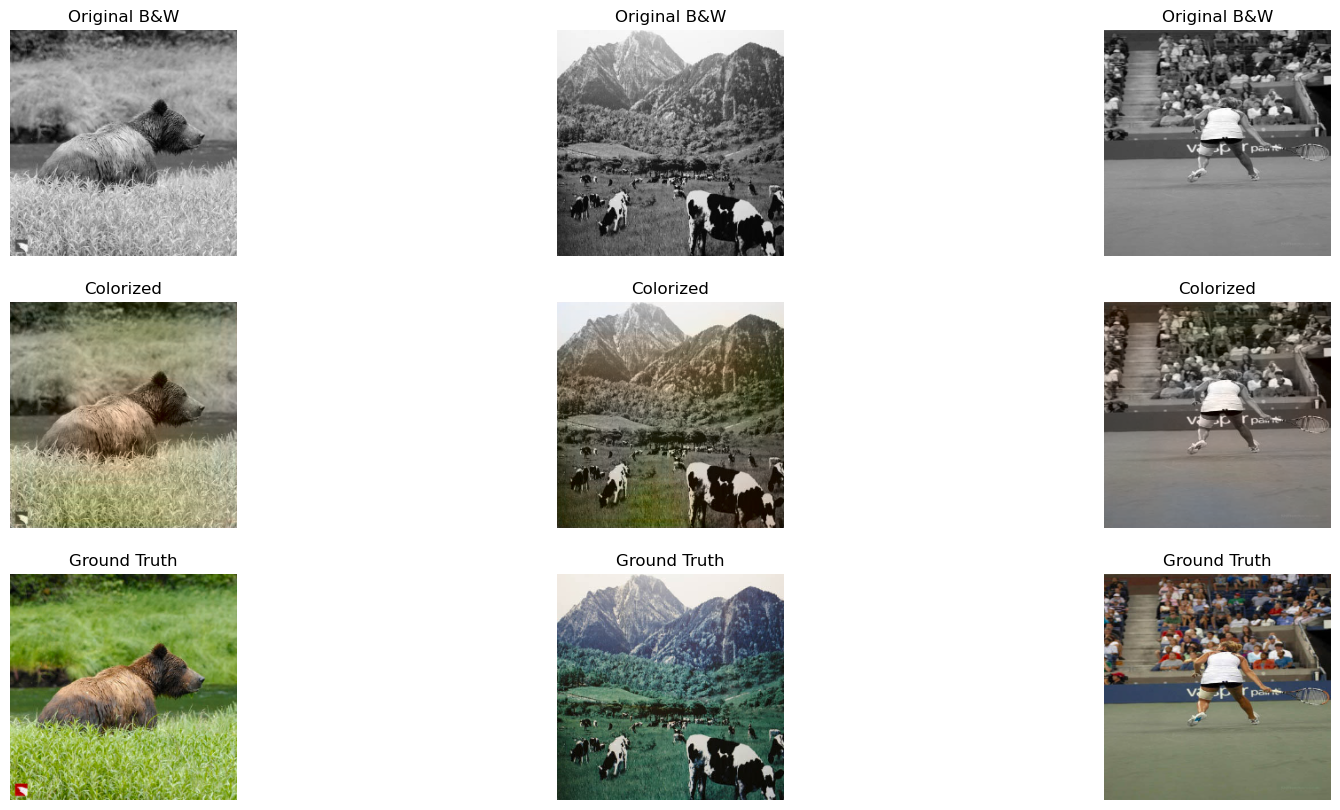

In [29]:
display_results(X_test_gray, y_test_ab, output)

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, RepeatVector, Reshape, concatenate
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from skimage.color import rgb2lab, rgb2gray, gray2rgb
from skimage.io import imread
from skimage.transform import resize

```markdown

### Model 3 : Inception + Custom Model (Transfer Learning)
Below code for building a colorization model using the InceptionResNetV2 architecture.

The code starts by loading the pre-trained InceptionResNetV2 model, which will be used to extract embeddings. The input shape for the embeddings is specified using the `embed_shape` parameter.

Next, the encoder part of the model is defined. It takes an input of shape `input_shape` and applies a series of convolutional layers to extract features. The output of the encoder is then fused with the embeddings using concatenation and additional convolutional layers.

The decoder part of the model upsamples the fused features to generate the colorized output. It consists of several convolutional and upsampling layers.

The model is then built and compiled using the Adam optimizer and mean squared error loss.

After initializing and compiling the model, the code creates embeddings using the InceptionResNetV2 model. The `create_inception_embedding` function is used to preprocess the input images, resize them to the required size, and generate embeddings using the InceptionResNetV2 model.

An image data generator is also created for data augmentation. It applies various transformations such as shear, zoom, rotation, and horizontal flip to the grayscale images.

Finally, the code generates the training data using the image data generator and specifies the batch size for training.

```

In [11]:
def build_colorization_model(input_shape=(256, 256, 1), embed_shape=(1000,)):

    # Load pre-trained InceptionResNetV2
    inception = InceptionResNetV2(include_top=True)

    # Input for embeddings from InceptionResNetV2
    embed_input = Input(shape=embed_shape)

    # Encoder
    encoder_input = Input(shape=input_shape)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(encoder_input)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(conv2)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(conv4)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    # Fusion
    fusion1 = RepeatVector(32 * 32)(embed_input)
    fusion2 = Reshape((32, 32, 1000))(fusion1)
    fusion3 = concatenate([conv8, fusion2], axis=3)
    fusion4 = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion3)

    # Decoder
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(fusion4)
    conv10 = UpSampling2D((2, 2))(conv9)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)
    conv12 = UpSampling2D((2, 2))(conv11)
    conv13 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv12)
    conv14 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv13)
    conv15 = Conv2D(2, (3, 3), activation='tanh', padding='same')(conv14)
    conv16 = UpSampling2D((2, 2))(conv15)

    # Build and compile model
    model = Model(inputs=[encoder_input, embed_input], outputs=conv16)
    model.compile(optimizer='adam', loss='mse')

    return model

# Initialize and compile the model
model = build_colorization_model(input_shape=(256, 256, 1))

# plot_model(model, show_shapes=True)

# Create embeddings using InceptionResNetV2
inception = InceptionResNetV2(include_top=True, weights='imagenet')

def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299))
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = tf.keras.applications.inception_resnet_v2.preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image data generator for augmentation
datagen = ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True)
datagen.fit(X_train_gray)

# Generate training data
batch_size = 20



225209952/225209952 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
You must install pydot (`pip install pydot`) for `plot_model` to work.


```markdown
## Training the Image Colorization Model

To train the image colorization model, follow these steps:

1. Calculate the number of steps per epoch by dividing the length of the training grayscale images (`X_train_gray`) by the batch size (`batch_size`). This determines how many batches of data will be processed in each epoch.

2. Print the value of `steps_per_epoch` to verify the number of steps.

3. Fit the model using the `image_a_b_gen` generator function, which generates batches of training data. Specify the number of epochs as 2000 and the `steps_per_epoch` as calculated in the previous step. Set the `verbose` parameter to 1 to display progress during training.

4. After training, save the trained model using the `save_model` function from `tensorflow.keras.models`. Provide the model object and specify the filename as "Image_colorization_model.h5".

Make sure to execute these code cells in order to train the model and save the trained model for future use.
```

In [78]:
steps_per_epoch = len(X_train_gray) // batch_size
print(steps_per_epoch)

# Train the model
model.fit(image_a_b_gen(batch_size), epochs=2000, steps_per_epoch=steps_per_epoch, verbose=1)

# Save the trained model
from tensorflow.keras.models import save_model
save_model(model, 'Image_colorization_model.h5')

StatementMeta(, eeac33e0-536e-4e08-94db-687a43acf305, 80, Finished, Available, Finished)

250
1/1 [==============================] - 2s 2s/step
Yielding batch 1/10
Epoch 1/50
1/1 [==============================] - 3s 3s/step
Yielding batch 2/10
1/1 [==============================] - 3s 3s/step
Yielding batch 3/10
1/1 [==============================] - 4s 4s/step
Yielding batch 6/10
1/1 [==============================] - 4s 4s/step
Yielding batch 7/10
1/1 [==============================] - 4s 4s/step
Yielding batch 10/10
250/250 [==============================] - 51s 179ms/step - loss: 0.1922
Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while s

2024-08-11 16:04:58.419823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-08-11 16:05:49.287580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2024-08-11 16:05:49.301531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2024-08-11 16:


### Load the model from the saved file

To load the trained model from the saved file, we are using the `load_model` function from `tensorflow.keras.models`


In [4]:
# Load the model from the saved file
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

model_path = '/lakehouse/default/Files/Image_colorization_model.h5'  # Adjust the path as needed
model = load_model(model_path)
inception = InceptionResNetV2(include_top=True, weights='imagenet')
print("Model loaded successfully!")

StatementMeta(, bdcc68b7-8465-4d77-b756-63312f23757f, 6, Finished, Available, Finished)

225209952/225209952 [==============================] - 2s 0us/step
Model loaded successfully!


In [5]:
#Make a prediction on the unseen images
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299))
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed
color_me = []
filename_list = []
for filename in os.listdir(os.path.join('/lakehouse/default','Files','data','image-colorization-via-transfer-learning','data','test_black'))[:3]:
    color_me.append(resize(img_to_array(load_img(os.path.join('/lakehouse/default','Files','data','image-colorization-via-transfer-learning','data','test_black/')+filename)),(400,400)))
    filename_list.append(filename)
#color_me.append(img_to_array(load_img('/kaggle/input/image-colorization-dataset/data/test_black/image5000.jpg')))
#color_me.append(img_to_array(load_img('/kaggle/input/image-colorization-dataset/data/test_black/image5001.jpg')))
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
color_me = gray2rgb(rgb2gray(color_me))
color_me_embed = create_inception_embedding(color_me)

color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))
print(filename_list)

StatementMeta(, bdcc68b7-8465-4d77-b756-63312f23757f, 7, Finished, Available, Finished)

(3, 400, 400, 3)
1/1 [==============================] - 4s 4s/step
['image5000.jpg', 'image5001.jpg', 'image5002.jpg']


In [6]:
output = model.predict([color_me, color_me_embed])
output = output * 128

StatementMeta(, bdcc68b7-8465-4d77-b756-63312f23757f, 8, Finished, Available, Finished)

1/1 [==============================] - 1s 659ms/step


In [ ]:
# Output colorizations
for i in range(len(output)):
    cur = np.zeros((400, 400, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    print(filename_list[i][:-4])
    plt.imsave(os.path.join('/lakehouse/default','Files','data','image-colorization-via-transfer-learning',f'{filename_list[i][:-4]}.png'), lab2rgb(cur))


Below code defines a function `display_results` that takes in three lists of image paths: `bw_images_paths`, `color_images_paths`, and `gt_images_paths`. It also has an optional parameter `n` which specifies the number of images to display (default is 3).

Inside the function, it creates a figure with a size of 20x10 using `plt.figure(figsize=(20, 10))`. Then, it iterates over the range of `num_images`, which is the minimum value between `n` and the length of `bw_images_paths`.

For each iteration, it performs the following steps:
1. Loads the original black and white image using `Image.open(bw_images_paths[i]).convert("L")` and assigns it to `bw_image`.
2. Creates a subplot for the original black and white image using `plt.subplot(3, num_images, i + 1)`.
3. Displays the black and white image using `plt.imshow(bw_image, cmap='gray')`.
4. Sets the title of the subplot as "Original B&W" using `plt.title("Original B&W")`.
5. Turns off the axis labels using `plt.axis("off")`.

The same steps are repeated for the colorized image and the ground truth image, with the appropriate modifications.

Finally, it shows the plot using `plt.show()`.

After defining the function, the code gets the paths for each image by calling the `find_image_file` function for each image name in `images_list`. It assigns the resulting paths to `bw_images_paths`, `color_images_paths`, and `gt_images_paths`.

Next, it filters out any `None` values from the image paths lists using list comprehension.

Finally, it calls the `display_results` function with the appropriate arguments to display the results.

StatementMeta(, bdcc68b7-8465-4d77-b756-63312f23757f, 17, Finished, Available, Finished)

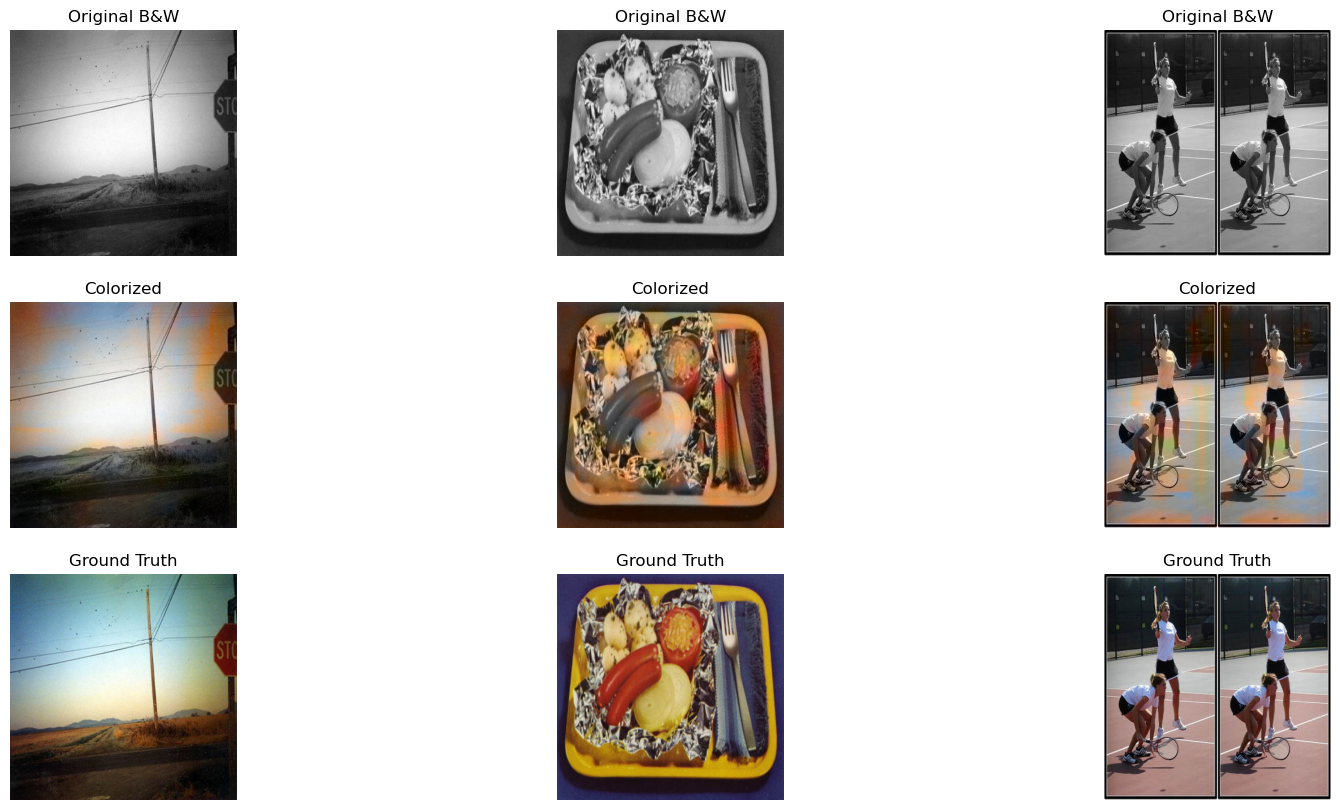

In [15]:
def display_results(bw_images_paths, color_images_paths, gt_images_paths, n=3):
    num_images = min(n, len(bw_images_paths))
    plt.figure(figsize=(20, 10))
    
    for i in range(num_images):
        # Display original black and white image
        bw_image = Image.open(bw_images_paths[i]).convert("L")
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(bw_image, cmap='gray')
        plt.title("Original B&W")
        plt.axis("off")

        # Display colorized image
        color_image = Image.open(color_images_paths[i]).convert("RGB")
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(color_image)
        plt.title("Colorized")
        plt.axis("off")

        # Display ground truth image
        gt_image = Image.open(gt_images_paths[i]).convert("RGB")
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(gt_image)
        plt.title("Ground Truth")
        plt.axis("off")
    
    plt.show()

# Get the paths for each image
bw_images_paths = [find_image_file(bw_images_path, image_name) for image_name in images_list]
color_images_paths = [find_image_file(ai_generated_path, image_name) for image_name in images_list]
gt_images_paths = [find_image_file(ground_truth_path, image_name) for image_name in images_list]

# Filter out None values if any images are not found
bw_images_paths = [path for path in bw_images_paths if path is not None]
color_images_paths = [path for path in color_images_paths if path is not None]
gt_images_paths = [path for path in gt_images_paths if path is not None]

# Display the results
display_results(bw_images_paths, color_images_paths, gt_images_paths, n=len(images_list))


## Conclusion

In this Jupyter Notebook, we explored different models for image colorization. We tried the Unet model, VGG16 with transfer learning, and the Inception model with transfer learning.

After experimenting with these models, we found that the transfer learning models (VGG16 and Inception) performed better and achieved good results in image colorization. Transfer learning allows us to leverage pre-trained models that have been trained on large datasets, enabling us to benefit from their learned features and improve the performance of our models.

The VGG16 model, which is a deep convolutional neural network, showed promising results in colorizing black and white images. By using transfer learning, we were able to fine-tune the model on our specific task and achieve good colorization results.

Similarly, the Inception model, which is another popular deep learning architecture, also performed well in image colorization. By using transfer learning and leveraging the pre-trained weights of the InceptionResNetV2 model, we were able to achieve accurate and visually appealing colorization results.

Overall, our experiments with transfer learning models demonstrated the effectiveness of leveraging pre-trained models for image colorization tasks. These models provide a powerful starting point and can significantly improve the performance and accuracy of our colorization models.

By combining the power of deep learning architectures with transfer learning, we can continue to explore and develop more advanced models for image colorization, pushing the boundaries of what is possible in this field.